## Pre-requisites

This Notebook requires the following to be installed on one's machine:

* **openmc** (tested on version 0.15.3)
* **beavrs**

**NOTE**: You can install the `beavrs` Python module by running the following in the terminal from the directory BEAVRS/models/openmc:

```
$ pip install . --user
```

In [ ]:
import openmc
import beavrs.builder
import beavrs.constants as c
from IPython.display import Image
import os

In [ ]:
# This example assumes the OPENMC_CROSS_SECTIONS environment variable has already been set 
# so that OpenMC can be called without having to specify the cross section data library.
# For users who do not have this environment variable set, please uncomment the following
# line and update the library path to the correct cross_sections.xml file
# os.environ["OPENMC_CROSS_SECTIONS"] = '/path/to/cross_sections.xml'

## Create BEAVRS Model

In [2]:
# Instantiate a BEAVRS object from the mit-crpg/PWR_benchmarks repository
b = beavrs.builder.BEAVRS()

The BEAVRS model represented by variable `b` encapsulates the fully-detailed 3D BEAVRS core geometry and materials built using the OpenMC Python API.

## Create "geometry.xml"

We wish to extract a fuel pin from the BEAVRS `Geometry` object for our simulation.

In [3]:
# User-specified enrichment of 1.6, 2.4 or 3.1 percent
enrichment = 1.6

In [4]:
# Extract fuel pin of interest from BEAVRS model
pin_name = 'Fuel rod active region - {}% enr'.format(enrichment)
pin = b.openmc_geometry.get_universes_by_name(pin_name)[0]

We can inspect our chosen fuel pin using OpenMC's built-in string representation for the object:

In [5]:
pin

Universe
	ID             =	8
	Name           =	Fuel rod active region - 1.6% enr
	Geom           =	CSG
	Cells          =	[52, 53, 54]

In [6]:
print(pin.cells)

{52: Cell
	ID             =	52
	Name           =	Fuel rod active region - 1.6% enr radial 0: Fuel 1.6%
	Fill           =	Material 9
	Region         =	-35
	Rotation       =	None
	Temperature    =	None
	Density        =	None
	Translation    =	None
	Volume         =	None
, 53: Cell
	ID             =	53
	Name           =	Fuel rod active region - 1.6% enr radial 1: Helium
	Fill           =	Material 5
	Region         =	(35 -36)
	Rotation       =	None
	Temperature    =	None
	Density        =	None
	Translation    =	None
	Volume         =	None
, 54: Cell
	ID             =	54
	Name           =	Fuel rod active region - 1.6% enr radial outer: Zircaloy 4
	Fill           =	Material 7
	Region         =	36
	Rotation       =	None
	Temperature    =	None
	Density        =	None
	Translation    =	None
	Volume         =	None
}


We need to wrap the fuel region with water to make a complete fuel pin:

In [7]:
# Create surface as the boundary of clad and cell pitches
fuel_clad_OR = openmc.ZCylinder(name='Fuel clad OR', r=c.cladOR)
pin_sides = openmc.model.RectangularPrism(c.pinPitch, c.pinPitch,
                                          axis ='z',
                                          boundary_type='reflective')
# Create a cell filled by the fuel pin
fuel_cell = openmc.Cell(name='Fuel cell',
                        fill=pin,
                        region=-fuel_clad_OR
                       )
water_cell = openmc.Cell(name='Water',
                        fill=b.mats['Borated Water'],
                        region=+fuel_clad_OR & -pin_sides
                       )

Then we construct a sub-geometry encapsulating only this fuel pin. We will do this by first creating a "root" universe and add our cells to it:

In [8]:
# Create a "root" universe with ID=0 and add the "root" cell to it
root_univ = openmc.Universe(name='root universe', cells=[fuel_cell, water_cell])

Lastly, the "root" universe must be attached to a new OpenMC `Geometry` object representing this new sub-geometry:

In [9]:
# Create an OpenMC Geometry around root Universe
sub_geometry = openmc.Geometry(root_univ)

Finally, we are ready to create a "geometry.xml" input file for OpenMC! We simply export it to XML as follows:

In [10]:
# Export the OpenMC Geometry to a "geometry.xml" file
sub_geometry.export_to_xml()

## Create "materials.xml"

Now we need to create materials for our geometry. This is very easy to do with the `b.write_openmc_materials()` routine. The one disadvantage of this is that it will write *all* materials for the entire BEAVRS geometry to a "materials.xml" file, most of which are not used in our sub-geometry for a single fuel pin. Instead, we can write out only those materials that are in our geometry as follows:

In [11]:
# Get a list of all OpenMC Materials
all_materials = sub_geometry.get_all_materials()

# Create a MaterialsFile object
materials = openmc.Materials(all_materials.values())

# Export the OpenMC Materials to a "materials.xml" file
materials.export_to_xml()

## Create "settings.xml" 

Now for the easy part :-) Let's create a "settings.xml" file:

In [30]:
# Create a MaterialsFile object
settings = openmc.Settings()

# Set any settings of interest
settings.batches = 150
settings.inactive = 10
settings.particles = 1000

# Use a bounding box to define the starting source distribution
lower_left = [-c.pinPitch/2, -c.pinPitch/2, c.fuel_ActiveFuel_bot]
upper_right = [c.pinPitch/2, c.pinPitch/2, c.fuel_ActiveFuel_top]
settings.source = openmc.IndependentSource(
    openmc.stats.Box(lower_left, upper_right), constraints={'fissionable': True})

# Set temperature handling method for cross section data
settings.temperature = {'method': 'interpolation',
                            'default': c.operating_temperature,
                            'range': (300.0, 600.0),
                            'tolerance': 100.0}

# Export the settings to a "settings.xml" file
settings.export_to_xml()

## Create "plots.xml"

In [19]:
# Create a single plot using default paramters (basis='xy', origin=(0,0,0))
plot = openmc.Plot(plot_id=1)
plot.width = [c.pinPitch, c.pinPitch]

# Create a PlotsFile object and add our plot to it
plot_file = openmc.Plots([plot])

# Export the plots to a "plots.xml" file
plot_file.export_to_xml()

With the "plots.xml" file, we can now generate and view the plot. We must first instantiate an `openmc.Executor` object and then ask it to plot the geometry(equivalent to running `openmc -p` from within the terminal).

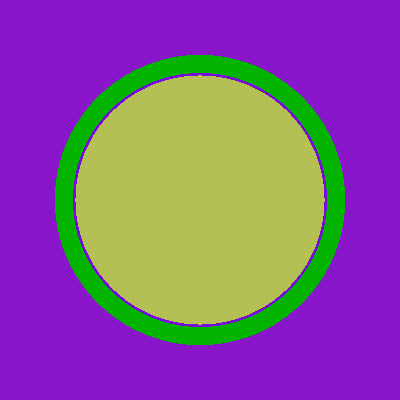

In [20]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

# Display the plot inline
Image(filename='plot_1.png', width=250, height=250)

## Create "tallies.xml"

Perhaps you'd like a tally in one of the cells. First, we need to extract the cell(s) of interest:

In [21]:
all_material_cells = sub_geometry.get_all_material_cells()

cell_name = 'Fuel rod active region - 1.6% enr radial 0: Fuel 1.6%'
for id, cell in all_material_cells.items():
    if cell.name == cell_name:
        my_cell = cell

Let's tally the fast/thermal scatter and absorption rates for all nuclides in our cell. We create a `Tally` to do so as follows:

In [22]:
# Instantiate a really cool tally
tally = openmc.Tally(name='a really cool tally')

# Instantiate a cell filter
cell_filter = openmc.CellFilter(bins=[my_cell.id])

# Instantiate energy filter
energy_filter = openmc.EnergyFilter([0., 0.625e-6, 20.])

tally.filters = [cell_filter, energy_filter]

# Add the scores of interest to the tally
tally.scores = ['scatter', 'absorption']

# Add all nuclides to the tally for kicks
tally.nuclides = my_cell.fill.get_nuclides()

Next, we simply need to add our `Tally` object(s) to a `TalliesFile` object and export them to a "tallies.xml" file:

In [23]:
# Instantiate an empty TalliesFile
tallies_file = openmc.Tallies()

# Add our tally(ies) to the file
tallies_file.append(tally)

# Export the tallies to a "tallies.xml" file
tallies_file.export_to_xml()

## Run OpenMC!

We can run OpenMC from within the notebook if we wish. Wow, isn't this so much more powerful than ASCII!

In [31]:
# Run OpenMC with 2 MPI processes
openmc.run(mpi_args=['mpiexec', '-n', '2'], threads=2)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Analyze Tally Data

In [32]:
# Instantiate a StatePoint object
from openmc.statepoint import StatePoint
filename = 'statepoint.{}.h5'.format(settings.batches)
sp = StatePoint(filename)

In [33]:
# Inspect the StatePoint's tallies
sp.tallies

{np.int32(1): Tally
 	ID             =	1
 	Name           =	a really cool tally
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	O16 O17 O18 U234 U235 U238 U236
 	Scores         =	['scatter', 'absorption']
 	Estimator      =	tracklength
 	Multiply dens. =	True}

In [34]:
# Get a Pandas DataFrame of the tally data
tally = sp.get_tally(name='a really cool tally')
tally.get_pandas_dataframe()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,52,0.000000e+00,6.250000e-07,O16,scatter,0.000000e+00,0.000000e+00
1,52,0.000000e+00,6.250000e-07,O16,absorption,0.000000e+00,0.000000e+00
2,52,0.000000e+00,6.250000e-07,O17,scatter,0.000000e+00,0.000000e+00
3,52,0.000000e+00,6.250000e-07,O17,absorption,0.000000e+00,0.000000e+00
4,52,0.000000e+00,6.250000e-07,O18,scatter,0.000000e+00,0.000000e+00
5,52,0.000000e+00,6.250000e-07,O18,absorption,0.000000e+00,0.000000e+00
6,52,0.000000e+00,6.250000e-07,U234,scatter,0.000000e+00,0.000000e+00
7,52,0.000000e+00,6.250000e-07,U234,absorption,0.000000e+00,0.000000e+00
8,52,0.000000e+00,6.250000e-07,U235,scatter,0.000000e+00,0.000000e+00
9,52,0.000000e+00,6.250000e-07,U235,absorption,0.000000e+00,0.000000e+00


And I'll leave it up to you at this point :-)